# Neural Quest Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1DF-OWSP803x34FrvaJ4XeDm_QZUevu32/view?usp=sharing)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

np.random.seed(69)

## Load *Dataset*
Load data from the given pickle file

In [3]:
# Download the dataset from the provided link
url = 'https://drive.google.com/uc?id=1DF-OWSP803x34FrvaJ4XeDm_QZUevu32'
response = requests.get(url)
content = response.content

# Load the dataset
dataset = pickle.loads(content)
#print(dataset.keys())

# Extract the features (X) and target (y) from the loaded data
X = dataset['X']
y = dataset['y']

# Normalize the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=69)

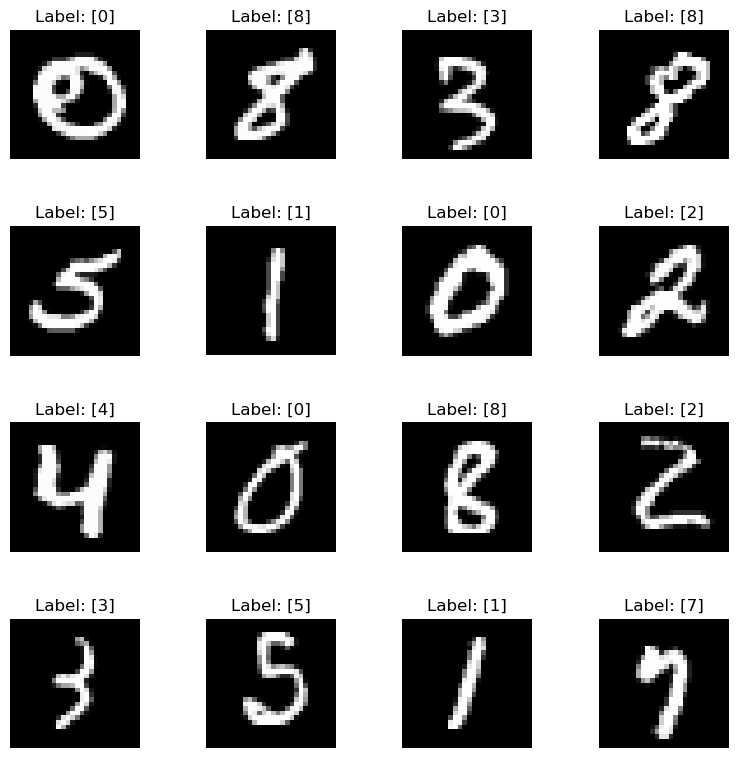

In [4]:
# Define the grid size
grid_size = (4, 4)

# Choose random indices for the images
random_indices = np.random.choice(len(X_train), size=grid_size[0]*grid_size[1], replace=False)

# Create the subplots
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(8, 8))
fig.tight_layout()

# Iterate over the subplots and display the images with labels
for i, ax in enumerate(axes.flat):
    image = X_train[random_indices[i]].reshape(28, 28)
    label = y_train[random_indices[i]]
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {label}")

# Display the grid of images
plt.show()


## Building up parts of our classifier

**Activation functions**

In [5]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    return np.maximum(0, z)

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    exps = np.exp(z)
    return exps / np.sum(exps, axis=1, keepdims=True)

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [6]:
def init_params(input_size, hidden_size, output_size):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    # Initialize weights
    W1 = np.random.randn(hidden_size, input_size) * 0.01
    W2 = np.random.randn(output_size, hidden_size) * 0.01
    
    # Initialize biases
    b1 = np.zeros((hidden_size, 1))
    b2 = np.zeros((output_size, 1))
    
    # Create the parameters dictionary
    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }
    
    return parameters

**Forward Propagation**

In [14]:
def forward_prop(X, weights):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    # Retrieve weights from the dictionary
    W1 = weights['W1']
    b1 = weights['b1']
    W2 = weights['W2']
    b2 = weights['b2']
    
    # Perform forward propagation
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    
    return Z2, Z1, A1, Z2, A2


**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [8]:
def backward_prop(weights, X, y, Z1, A1, Z2, A2):
    """
    Performs backward propagation and updates the weights for the neural network.
    """
    # Retrieve weights from the dictionary
    W1 = weights['W1']
    b1 = weights['b1']
    W2 = weights['W2']
    b2 = weights['b2']
    
    # Compute the gradients
    m = X.shape[1]  # Number of training examples
    dZ2 = A2 - y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (A1 > 0)
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    # Update the weights
    updated_weights = {
        'W1': W1 - dW1,
        'b1': b1 - db1,
        'W2': W2 - dW2,
        'b2': b2 - db2
    }
    
    return updated_weights


In [9]:
def cost_func(weight,y,params):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    # Retrieve weights from the dictionary
    W1 = weights['W1']
    b1 = weights['b1']
    W2 = weights['W2']
    b2 = weights['b2']
    
    # Perform forward propagation
    Z1 = np.dot(W1, params['X']) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    
    # Compute the loss
    m = params['X'].shape[1]  # Number of training examples
    loss = -np.sum(y * np.log(A2)) / m
    
    return loss


## Integrate everything

In [10]:
def train(X, y, hidden_nodes, epochs=1000, lr=1e-5):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    
    input_size = X.shape[0]  # Size of the input layer
    output_size = y.shape[0]  # Size of the output layer
    
    
    # initialize weights.
    
    weights = init_params(input_size, hidden_nodes, output_size)

    for i in range(epochs):
        # forward propagation
        
        Z2, Z1, A1, Z2, A2 = forward_prop(X, weights)

        # print cost at every 100 or so iterations
        
        if i % 100 == 0:
            cost = cost_func(weights, y, {'X': X})
            print(f"Cost after {i} epochs: {cost}")
            
        # backward propagation
        
        weights = backward_prop(weights, X, y, Z1, A1, Z2, A2)
        
        for key in weights:
            weights[key] -= lr * weights[key]
    
    return weights

In [11]:
def predict(X, updated_weights):
    """
    returns the prediction in [0,9] for each element in X
    """
    
    # Perform forward propagation
    Z2, _, _, _, A2 = forward_prop(X, updated_weights)
    
    # Get the index of the maximum probability for each example
    predictions = np.argmax(A2, axis=0)
    
    return predictions

In [12]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    
    num_correct = np.sum(predictions == y)
    accuracy = num_correct / y.shape[0] * 100
    
    # Print the accuracy
    print(f"Accuracy: {accuracy}%")

In [15]:
train(X_train, y_train, 69)

NameError: name 'weights' is not defined

### Save as pickle

In [18]:
import pickle
import random
from google.colab import files

roll_num = "22B1027" # enter ldap
hidden_dim = 69 # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': pass, # layer 0 weight (784, z)
    'layer_0_bias': pass, # layer 0 bias (z, 1)
    'layer_1_wt': pass, # layer 1 weight (z, 10)
    'layer_1_bias': pass # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

SyntaxError: invalid syntax (2007299608.py, line 10)